# Grad-CAM

> Generalizing the idea proposed in CAM by eliminating the need of special archicture requirements. Grad-CAM uses gradient of target class wrt to activation maps to produce channel weights, thus it could be applied to wide range of Deep learning tasks for "Model Interpretability"

Paper: [Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

Since entire training process is same as of CAM [notebook](https://kshitij09.github.io/fast_impl/visualization.cam/), clubbing it in a single cell

# Data

In [ ]:
from fastai2.vision.all import *
from fast_impl.core import arch_summary, get_module, min_max_scale

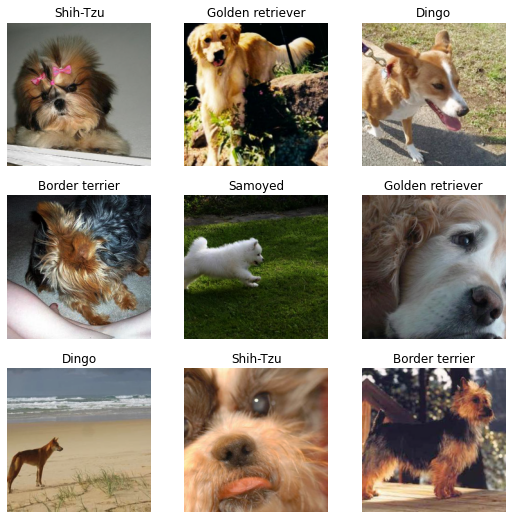

In [ ]:
path = untar_data(URLs.IMAGEWOOF_320)

lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(valid_name='val'),
                   get_y=Pipeline([parent_label,lbl_dict.__getitem__]),
                   item_tfms=Resize(320),
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path,bs=128)
dls.show_batch()

# Learner

In [ ]:
exp_name='resnet34'
save_model = SaveModelCallback(monitor='error_rate',fname=exp_name)
learn = cnn_learner(dls,resnet34,metrics=error_rate,model_dir='/content/models',
                    cbs=save_model,opt_func=ranger)

In [ ]:
learn.fit_flat_cos(5,lr=1e-3)
learn.unfreeze()
learn.fit_flat_cos(4,lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,1.225215,0.237496,0.073301,01:01
1,0.513202,0.187947,0.060575,01:00
2,0.304128,0.174078,0.052431,01:00
3,0.234934,0.169510,0.051667,00:59
4,0.198136,0.165612,0.051922,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.192194,0.173631,0.051667,01:14
1,0.165483,0.178599,0.050649,01:13
2,0.136138,0.181157,0.049885,01:14
3,0.106005,0.176875,0.052431,01:13


# Grad-CAM

1. gradient of score of class c, $y^c$ wrt feature map activations $A^k$ global-average-pooled over width and height dimensions

$$\alpha^c_k = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

2. weighted combination of forward activation maps, followed by ReLU
$$L_{Grad-CAM}^C = ReLU (\sum_k \alpha^c_kA^k)$$

In [ ]:
m = learn.model

In [ ]:
xb,yb = dls.one_batch()

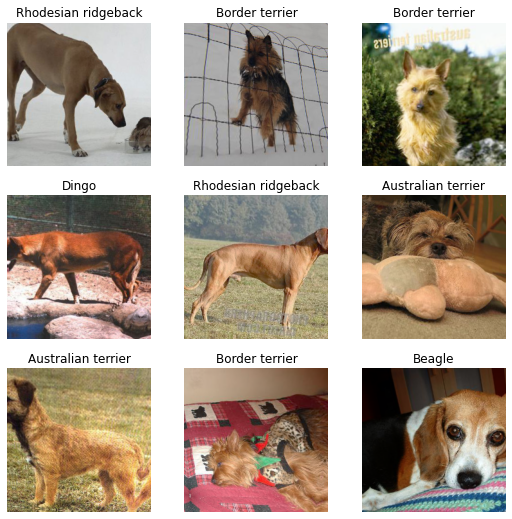

In [ ]:
dls.show_batch((xb,yb),max_n=9)

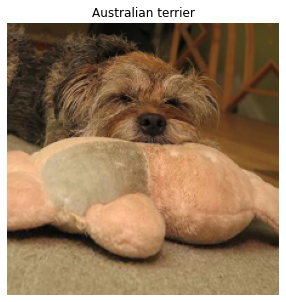

In [ ]:
idx=5
xb,yb = xb[idx][None],yb[idx][None]
x_dec,y_dec = learn.dls.decode_batch((xb,yb))[0]
show_image(x_dec,title=y_dec,figsize=(5,5));

In [ ]:
hook,hook_g = hook_output(m[0]), hook_output(m[0],grad=True)

In [ ]:
m.zero_grad()
preds = m.eval()(xb)
preds[0,preds.argmax().item()].backward(retain_graph=True)

In [ ]:
dls.vocab[preds.argmax().item()]

'Australian terrier'

In [ ]:
hook.stored[0].shape, hook_g.stored[0].shape

(torch.Size([512, 7, 7]), torch.Size([1, 512, 7, 7]))

In [ ]:
acts, grads = hook.stored[0], hook_g.stored[0][0]

In [ ]:
alpha = grads.mean((1,2),keepdim=True); alpha.shape

torch.Size([512, 1, 1])

In [ ]:
gcam = F.relu((alpha * acts).sum(0)); gcam.shape

torch.Size([7, 7])

In [ ]:
def show_heatmap(x,cam,sz,merge=False,figsize=(7,7),
                 alpha=0.6,interpolation='spline36',
                 cmap='magma'):
  "Used to show CAM/gradcam"
  if merge: figsize=(4,4)
  if not merge: alpha=1.
  _,axs = subplots(1,1 if merge else 2,figsize=figsize)
  if not isinstance(x,TensorImage): x = TensorImage(x)
  x.show(ax=axs[0],title='Image' if not merge else None)
  if cam.dim()==2: cam = cam[None]
  show_image(min_max_scale(cam),ax=axs[0 if merge else 1],
             extent=(1,sz,sz,1),alpha=alpha,
             interpolation=interpolation,cmap=cmap,
             title='Heatmap' if not merge else None);

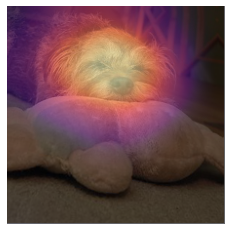

In [ ]:
show_heatmap(x_dec,gcam,224,merge=True, interpolation='spline36')

# Custom test image

Fastai2 specific steps have been described in the [CAM](https://kshitij09.github.io/fast_impl/visualization.cam/) notebook, so borrowing the same code here

In [ ]:
# It's an image of Shih-tzu
url = 'https://t2conline.com/wp-content/uploads/2020/01/shutterstock_1124417876.jpg'
fname = 'test-shih-tzu.jpg'
download_url(url,dest=fname)

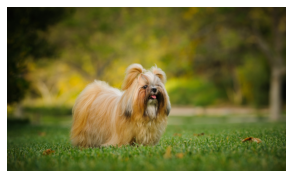

In [ ]:
img = PILImage.create(fname); img.show(figsize=(5,5));

In [ ]:
def create_batch(fname,lbl_idx):
  """Create test_batch from filename and label index
  Refer `dls.vocab` to find validation index
  """
  x = PILImage.create(fname)
  xb, = first(dls.test_dl([img]))
  yb = dls.categorize(dls.vocab[-1])[None]
  return xb,yb

In [ ]:
# As per the mapping dictionary, 'Shih Tzu' is the 10th class
xb,yb = create_batch(fname,9)

In [ ]:
def show_gradcam(learn, xb,yb=None,act_path:list=[0],merge=True):
  """Show Grad-CAM for a given image
  `learn`: fastai2 Learner
  `xb,yb`: input batch 
  `act_path`: list of indices to reach activation map layer
  `merge`: to use same axis for image and mask
  """
  m = learn.model
  hook_layer = get_module(m,act_path)
  # pdb.set_trace()
  with hook_output(hook_layer,grad=True) as hook_g:
    with hook_output(hook_layer) as hook:      
      m.zero_grad()
      y_pred = m.eval()(xb)
      y = y_pred.argmax().item()
      # pdb.set_trace()
      y_pred[0,y].backward(retain_graph=True)
      acts = hook.stored[0]
    # pdb.set_trace()
    grads = hook_g.stored[0]    
    alpha = grads.mean((2,3))
    gcam = F.relu(torch.einsum('ab,bcd->acd',alpha,acts))[0]
    x_dec,y_dec = learn.dls.decode_batch((xb,yb))[0]
    # pdb.set_trace()
    # gt_cls = dls.vocab[int(y_dec)] if y_dec is not None else ''
    pred_cls = dls.vocab[y]
    print(f"{'Actual':<9}: {ifnone(y_dec,'')}\nPredicted: {pred_cls}")
    show_heatmap(x_dec,min_max_scale(gcam),xb.shape[-1],merge=merge, interpolation='spline36')

Actual   : Shih-Tzu
Predicted: Shih-Tzu


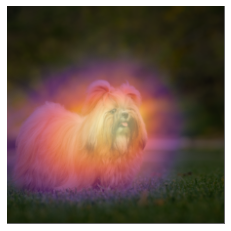

In [ ]:
show_gradcam(learn,xb,yb,act_path=[0])

Actual   : Shih-Tzu
Predicted: Shih-Tzu


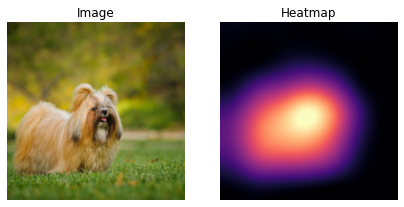

In [ ]:
show_gradcam(learn,xb,yb,act_path=[0],merge=False)

The novelty with Grad-CAM is that, we can look at the activations of any layer. Let's first have a brief view of the architecture and then decide which layer to visualize

In [ ]:
arch_summary(learn.model,verbose=True)

[0 ] Sequential       : 8   layers
      Conv2d
      BatchNorm2d
      ReLU
      MaxPool2d
      Sequential
      Sequential
      Sequential
      Sequential
[1 ] Sequential       : 9   layers
      AdaptiveConcatPool2d
      Flatten
      BatchNorm1d
      Dropout
      Linear
      ReLU
      BatchNorm1d
      Dropout
      Linear


With `m[0]`, we just looked at the activations of first sequential layer. Let's visualize the 2nd last block of our first sequential layer

Actual   : Shih-Tzu
Predicted: Shih-Tzu


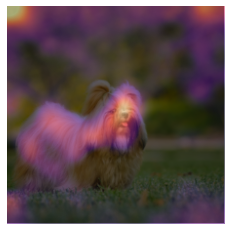

In [ ]:
show_gradcam(learn,xb,yb,act_path=[0,-2])